<a href="https://colab.research.google.com/github/Akkki28/fashion-generation-using-GANs/blob/main/FashionMNISTGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [1]:
import os

import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras.layers import Input, Reshape
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [3]:
N,H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)
print(D)

784


# Display images from the original dataset

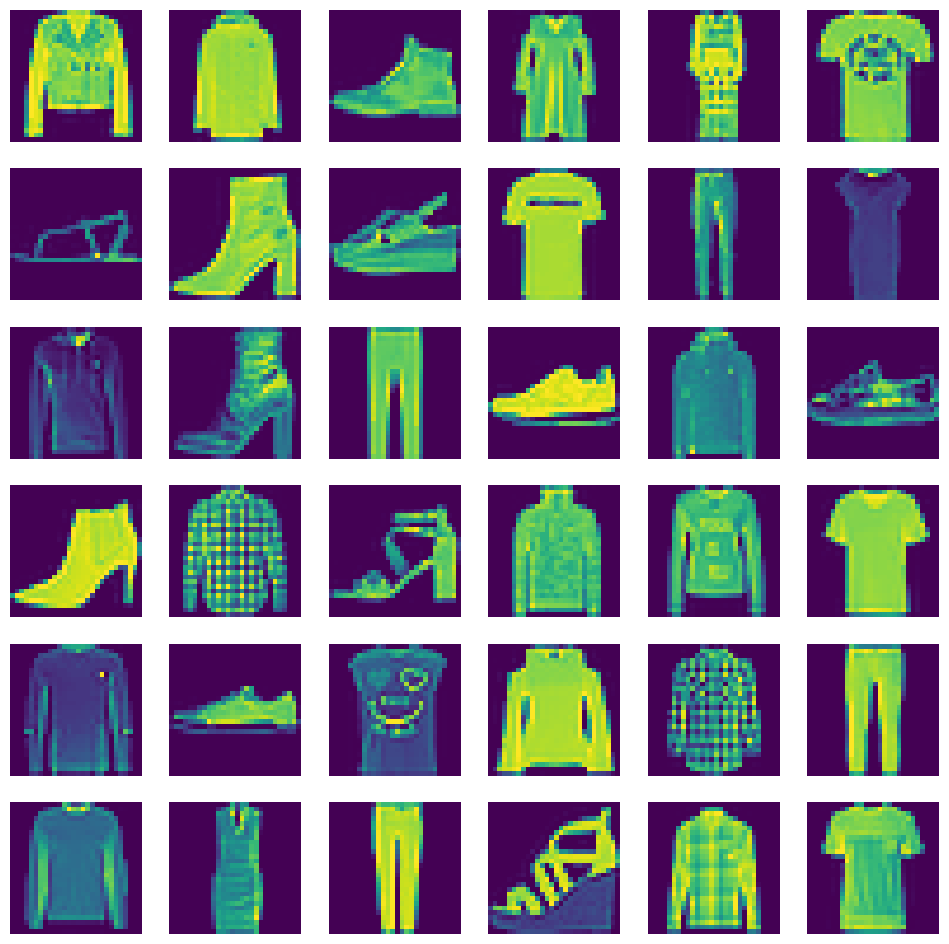

In [4]:
import matplotlib.pyplot as plt
import random
plot = x_train.reshape((-1, 28, 28))

np.random.shuffle(plot)

fig = plt.figure(figsize=(12,12))
for i in range(1,37):
    fig.add_subplot(6,6,i)
    plt.imshow(plot[i])
    plt.axis('off')

In [5]:
latent_dim = 100

# Build Generator Fuction

In [6]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

# Build Discriminator Fuction

In [7]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

# Compile the model

In [8]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)


combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
batch_size = 32
epochs = 20001
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [10]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

# Train the model

In [11]:

for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)


  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step
epoch: 15101/20001, d_loss: 0.67,       d_acc: 0.52, g_loss: 0.74
1/1 [==============================] - 0s 17ms/step
epoch: 15201/20001, d_loss: 0.70,       d_acc: 0.50, g_loss: 0.71
1/1 [==============================] - 0s 23ms/step
epoch: 15301/20001, d_loss: 0.70,       d_acc: 0.55, g_loss: 0.73
1/1 [==============================] - 0s 25ms/step
epoch: 15401/20001, d_loss: 0.68,       d_acc: 0.62, g_loss: 0.73
1/1 [==============================] - 0s 16ms/step
epoch: 15501/20001, d_loss: 0.70,       d_acc: 0.56, g_loss: 0.76
1/1 [==============================] - 0s 16ms/step
epoch: 15601/20001, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.74
1/1 [==============================] - 0s 16ms/step
epoch: 15701/20001, d_loss: 0.70,       d_acc: 0.45, g_loss: 0.73
1/1 [==============================] - 0s 16ms/step
epoch: 15801/20001, d_loss: 0.75,       d_acc: 0.42, g_loss: 0.72
1/1 [

# Improvement in image quality per epoch

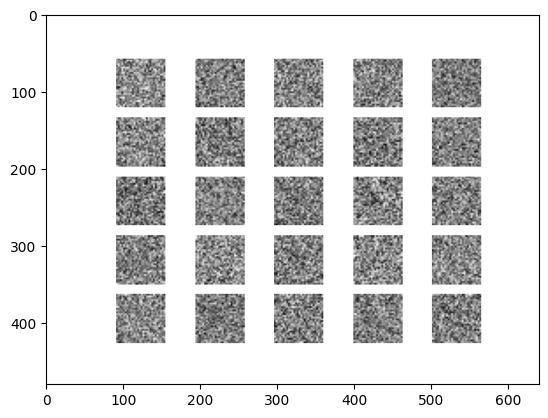

In [12]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

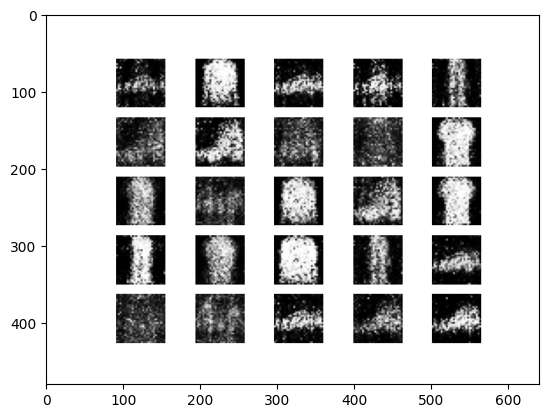

In [13]:
a = imread('gan_images/1000.png')
plt.imshow(a)

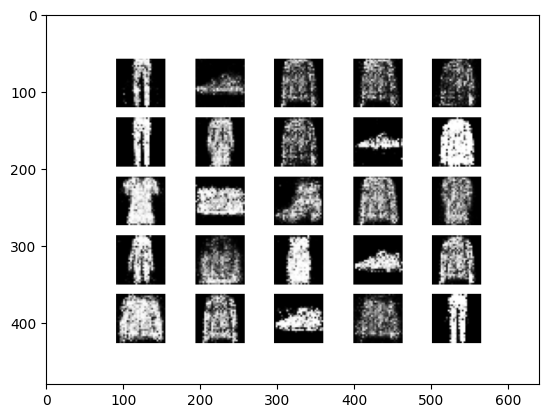

In [14]:
a = imread('gan_images/5000.png')
plt.imshow(a)

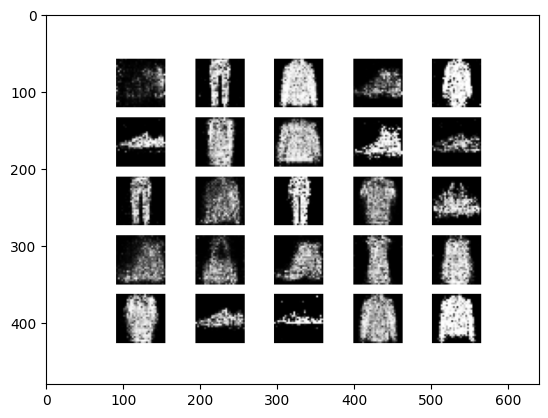

In [15]:
a = imread('gan_images/8000.png')
plt.imshow(a)

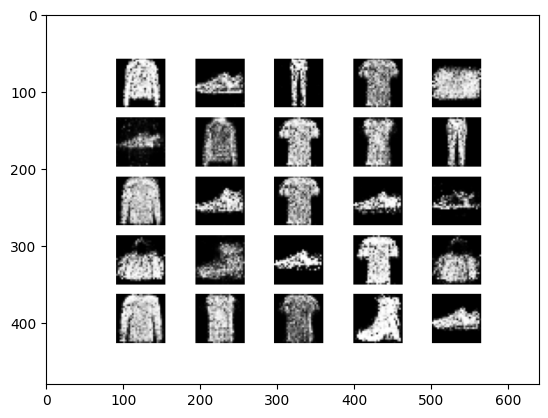

In [16]:
a = imread('gan_images/12000.png')
plt.imshow(a)

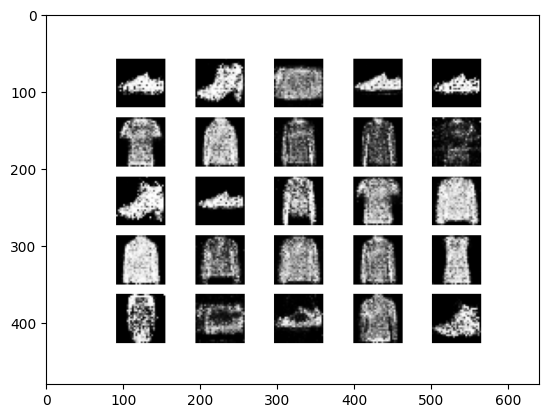

In [17]:
a = imread('gan_images/15000.png')
plt.imshow(a)

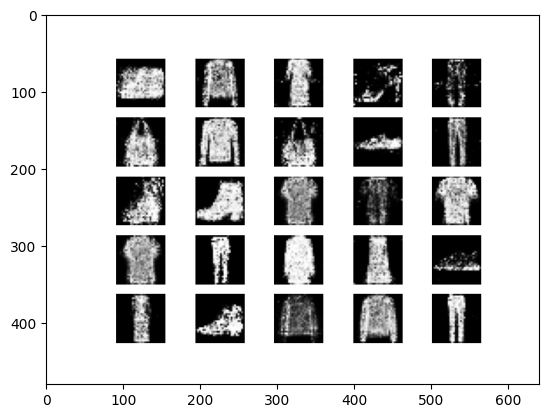

In [18]:
a = imread('gan_images/18000.png')
plt.imshow(a)

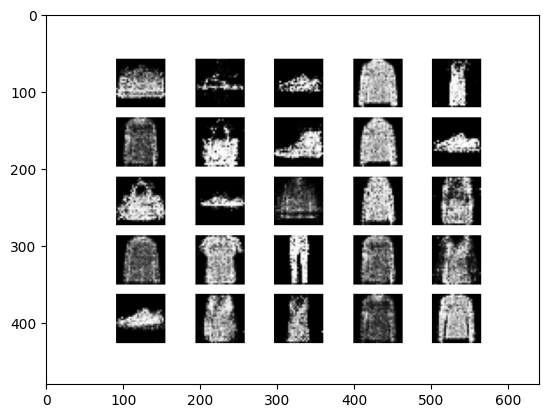

In [19]:
a = imread('gan_images/20000.png')
plt.imshow(a)

# Losses Of the generator and discriminator per epoch

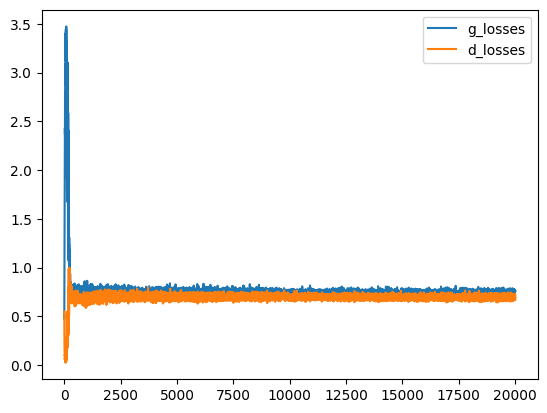

In [20]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()